# Model Selection 
___

**Objective:** Select a model that can achieve a Mean Absolute Error of up to R$ 500 in mothly income prediction.  
 
- **MAE** was selected as the metric because it is easy to interpret and appropriate for the salary scenario.   
- The threshold of **R$ 500** was selected because it is reasonable for the data range and adds up to a prediction margin of R$ 1,000.   

**Process:**

1. Import libraries, modules, functions, classes, and the dataset
2. Train a baseline model and evaluate its performance
    - I'll use a default Random Forest because I think the reasoning to determine salary is similar to a tree-thought process
3. Optmize the baseline model with hyperparameter tuning
4. Train and optmize a boosting method to compare against bagging
5. Evaluate whether a combination of both will work better than a single model
____

## 1. Importing

In [1]:
# Adding src to the path for modules
import sys
import os
root_path = os.path.abspath('..')
src_path = os.path.join(root_path, 'src')
sys.path.append(src_path)

# Project variables and functions
import config 
import utils
from preprocessing import pre_processing, divide_train_test
import importlib
importlib.reload(utils)

# Data manipulation
import pandas as pd
import numpy as np

# Models and metrics
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Importing and dividing the data:

In [2]:
# Imports data and divide it into training and testing
X_train, X_test, y_train, y_test = divide_train_test(
    utils.read_compressed_data(config.COLLECTED_DATA_PATH),
    config.FEATURES,
    config.TARGET
)

# Shows first lines on X_train
X_train.head()

,state,age,sex,race,literate,highest_educational_level,years_studied,worker_type,work_segment,occupation_group,tax_payer,weekly_worked_hours,weekly_worked_hours_all_jobs
206997,DF,57,2,4,1,3,9,4,11,9,2,3,40
653228,CE,33,1,4,1,7,16,7,8,2,1,3,40
596722,PR,22,2,1,1,6,13,1,7,4,1,3,40
322304,BA,24,1,4,1,5,12,1,10,5,1,4,48
121644,AM,45,1,1,1,2,6,9,5,8,2,4,45


___

## 2. Train Baseline Model (Default Random Forest):

In [3]:
# Creates a baseline pipeline using default random forest
baseline = Pipeline(
    steps=[
        ('pre_processing', pre_processing),
        ('model', RandomForestRegressor(random_state=0))
    ]
)

# Fits 
baseline.fit(X_train, y_train)

Pipeline(steps=[('pre_processing',
                 Pipeline(steps=[('add region',
                                  AddFeature(existing_column='state',
                                             function=<function return_region at 0x0000018968AFD280>,
                                             new_feature_name='region')),
                                 ('add white mixed-race',
                                  AddFeature(existing_column='race',
                                             function=<function return_white_mixed_race at 0x0000018968AFD940>,
                                             new_feature_name='white_mixed_race')),
                                 ('add high schoo...
                                             function=<function discretize_weekly_worked_hours_all_jobs at 0x0000018968AFD820>,
                                             new_feature_name='weekly_worked_hours_v2')),
                                 ('add studied years',
                                  AddFeature(existing_column='years_studied',
                                             function=<function discretize_years_studied at 0x0000018968AFD8B0>,
                                             new_feature_name='studied_years_v2')),
                                 ('target encoder',
                                  CategoricalTargetEncoder())])),
                ('model', RandomForestRegressor(random_state=0))])

Evaluating Feature Importance:

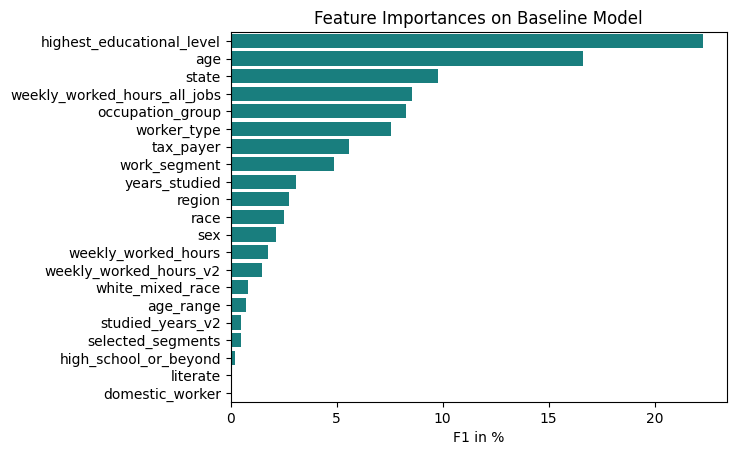

In [4]:
# Understand feature importances

# Starts with original features
features = list(X_train.columns)

# Appends new features
for i in range(len(baseline['pre_processing'])-1):
    features.append(baseline['pre_processing'][i].get_params()['new_feature_name'])

# Obtains feature importances and multiply by 100 to make a percentage
fi = np.array(baseline['model'].feature_importances_) * 100

# Combines everything in a Series
fi_series = pd.Series(fi, index=features)

# Sorts fi_series
fi_series.sort_values(ascending=False, inplace=True)

# Plots ranking
utils.show_barplot(
    cat=fi_series.index,
    values=fi_series,
    title='Feature Importances on Baseline Model',
    x_label='F1 in %'
)

Evaluating predictions with MAE and other complementary metrics:

In [5]:
baseline_pred = baseline.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, baseline_pred)}')
print(f'MAE: {mean_absolute_error(y_test, baseline_pred)}')
print(f'R²: {utils.make_percentage(r2_score(y_test, baseline_pred))}')

MSE: 1634963.5947739175
MAE: 789.6501416855427
R²:  50.79%
